In [78]:
import pandas as pd
import geopandas as gpd
import json
import requests
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load data and combine
1. Load Aleph wind farms
2. Load MapStand data
3. Combine
4. Save

## Load Aleph Data
need to add content of ftm  env to current environment for this to work


In [4]:
host = "https://data.ftm.nl/"
api_key = "Ai9e2w9tc95-JsvrbGQSX4moHgriPD2nm3lo9TogC_k"
foreign_id = "ce5001727ffb4d3cb42cc8c594395c22"
fn = r"C:\Users\n649505\code\ftm_north_sea_data\north_sea_wind_assets.csv"
#os.system("alephclient --host %s --api-key %s stream-entities -f %s -s Asset > %s" % (host, api_key, foreign_id, fn))
print("alephclient --host %s --api-key %s stream-entities -f %s -s Asset > %s" % (host, api_key, foreign_id, fn))

alephclient --host https://data.ftm.nl/ --api-key Ai9e2w9tc95-JsvrbGQSX4moHgriPD2nm3lo9TogC_k stream-entities -f ce5001727ffb4d3cb42cc8c594395c22 -s Asset > C:\Users\n649505\code\ftm_north_sea_data\north_sea_wind_assets.csv


Saved format from Aleph is funky. Open in MS Excel and save as csv

In [93]:
data_fn = "../ftm_north_sea_data/north_sea_wind_assets.csv"

raw_df = pd.read_csv(data_fn,header=None, encoding="utf-8")

asset_df = pd.json_normalize([json.loads(line) for line in raw_df[0].tolist() if json.loads(line)["schema"]=="Asset"])

asset_df.rename(columns={"properties.name":"name", "properties.notes": "status", "properties.country": "country", "properties.description": "mps_id", 
                         "properties.amountEur": "value_eur", "properties.publisherUrl": "source", "properties.amount": "installed_capacity_mw",
                         "id": "aleph_id"}, inplace=True)

cols = ["name", "status", "installed_capacity_mw", "country", "mps_id", "value_eur", "source"]
for col in cols:
    asset_df[col] = asset_df[col].apply(lambda x: ", ".join(x) if isinstance(x, list) else x)
asset_df.head()

,schema,aleph_id,name,status,country,value_eur,mps_id,source,properties.alephUrl,installed_capacity_mw,properties.alias,properties.summary
0,Asset,466b78bf-cdfe-4b90-95f6-2f3a2b0c3856.83db3a32d...,BEECH,EXCLUSIVE_DEVELOPMENT_RIGHTS,gb,11700000000,1042228e-6a6d-4df1-bef2-79b7ac38b1cd,"https://www.mapstand.com/, https://www.reuters...",[https://data.ftm.nl/api/2/entities/466b78bf-c...,NaN,NaN,NaN
1,Asset,70abe766-d491-411f-8242-53858c61e9aa.c0a7f7675...,BUTENDIEK,OPERATIONAL,de,1291000000,0d70f119-152e-4315-a56c-bb4f7360e38d,"https://www.mapstand.com/, https://www.eib.org...",[https://data.ftm.nl/api/2/entities/70abe766-d...,288 MW,NaN,NaN
2,Asset,c241d812-4a61-4fd0-bf7d-83e547fa2173.0eac4c598...,BP ALTERNATIVE ENERGY INVESTMENTS - INTOG APP 4,EXCLUSIVE_DEVELOPMENT_RIGHTS,gb,NaN,5e5d6150-89af-4713-92cd-8a195c5ba470,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/c241d812-4...,NaN,NaN,NaN
3,Asset,b950b829-ca77-46c4-8f46-97fef5d9bf8c.144baac18...,ARCADIS OST 1,UNDER_CONSTRUCTION,de,672000000,262ded14-e16c-43d3-a8d8-0b629cd2fdc7,https://www.eib.org/en/projects/pipelines/all/...,[https://data.ftm.nl/api/2/entities/b950b829-c...,NaN,NaN,NaN
4,Asset,d8889564-370a-4573-9483-468d761dad22.3c370af9c...,CELTIC DEEP PHASE 2,PROJECT_ANNOUNCED,gb,NaN,4ec3c918-4179-4fb4-bb45-c9cdd099f081,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/d8889564-3...,NaN,NaN,NaN


## Load MapStand

In [22]:
token_wfs = "0f5ed330-90f4-4f28-9214-5d981f3db642"
token_wms = "74d99a64-fdf4-4641-a390-c909665414ff"

url = "https://hub.mapstand.com/gs/ows?service=WFS&VERSION=1.0.0&request=GetFeature&typename=mps:powerplant_windfarm_installed&outputFormat=json&srsName=EPSG:4326&apikey=%s" % token_wms
response = requests.get(url)
data = response.json()["features"]
gdf_installed = gpd.GeoDataFrame.from_features(data, crs=4326)

url = "https://hub.mapstand.com/gs/ows?service=WFS&VERSION=1.0.0&request=GetFeature&typename=mps:powerplant_windfarm_planned&outputFormat=json&srsName=EPSG:4326&apikey=%s" % token_wms
response = requests.get(url)
data = response.json()["features"]
gdf_planned = gpd.GeoDataFrame.from_features(data, crs=4326)

url = "https://hub.mapstand.com/gs/ows?service=WFS&VERSION=1.0.0&request=GetFeature&typename=mps:wind_development_zone&outputFormat=json&srsName=EPSG:4326&apikey=%s" % token_wms
response = requests.get(url)
data = response.json()["features"]
gdf_wdz = gpd.GeoDataFrame.from_features(data, crs=4326)

#concatenate
rdf = gpd.GeoDataFrame(pd.concat((gdf_planned, gdf_installed, gdf_wdz), ignore_index=True), crs=gdf_planned.crs)

# save
rdf.head()

,geometry,admin_area_name,attribution,capacity_mw,coast_distance,description,installation_year,mps_created_time,mps_datasource_tags,mps_est_area_sqkm,...,operator,operator_group,owner,owner_group,round_name,status,updt,windfarm_type,closure_year,decommissioning_year
0,"MULTIPOLYGON (((21.76269 62.73501, 21.76277 62...",Finland,Copyright licensed from MapStand Limited under...,35.00,NaN,Operator: VINDIN PORTOM AB/OY. Further Informa...,NaN,2021-10-19T03:35:47.127Z,Data derived from Finnish Wind Power Associati...,25.001204,...,None,None,None,None,None,EARLY_PLANNING,2023-03-21T20:33:45.543Z,ONSHORE,NaN,NaN
1,"MULTIPOLYGON (((2.31715 50.60591, 2.31715 50.6...",France,Copyright licensed from MapStand Limited under...,11.75,NaN,None,NaN,2022-03-03T14:36:23.568Z,"Data derived from DREAL Hauts de France, 2022,...",1.176519,...,None,None,None,None,None,APPLICATION_REFUSED,2022-04-13T16:22:25.076Z,ONSHORE,NaN,NaN
2,"MULTIPOLYGON (((108.29105 10.96667, 108.28006 ...",Vietnam,Copyright licensed from MapStand Limited under...,40.00,NaN,None,NaN,2021-10-19T03:26:12.520Z,MOIT - GIZ Energy Support Programme,12.046565,...,None,None,None,None,None,CONSENT_AUTHORISED,2022-02-28T17:36:34.185Z,ONSHORE,NaN,NaN
3,"MULTIPOLYGON (((-7.92288 43.43422, -7.92282 43...",Spain,Copyright licensed from MapStand Limited under...,50.00,NaN,None,NaN,2022-01-07T15:04:13.832Z,"Data derived from Greenalia, 2022, (https://gr...",3.999792,...,"GREENALIA WIND POWER, S.L.U.",GREENALIA SA (GROUP),"GREENALIA WIND POWER, S.L.U.",GREENALIA SA (GROUP),None,EARLY_PLANNING,2022-04-13T16:17:37.461Z,ONSHORE,NaN,NaN
4,"MULTIPOLYGON (((-3.78490 55.77035, -3.78531 55...",United Kingdom,Copyright licensed from MapStand Limited under...,NaN,NaN,None,NaN,2022-03-25T20:19:32.234Z,"Data derived from UK Government, 2022, (https:...",6.289144,...,None,None,None,None,None,CONSENT_AUTHORISED,2022-04-13T16:22:16.365Z,ONSHORE,NaN,NaN


In [94]:
merged = pd.merge(asset_df, rdf[["mps_uuid", "capacity_mw", "geometry", "installation_year", "mps_est_elevation_min_m", "mps_est_shore_status", "windfarm_type", "mps_est_area_sqkm"]],
          left_on = "mps_id", right_on="mps_uuid", how="left")

# update capacities with manually entered ones
merged["capacity"] = pd.to_numeric(merged.installed_capacity_mw.apply(lambda x: x.strip(" MW") if isinstance(x, str) else x)).fillna(merged.capacity_mw)

In [95]:
merged[merged.mps_uuid.isna()]#.mps_id.tolist()

,schema,aleph_id,name,status,country,value_eur,mps_id,source,properties.alephUrl,installed_capacity_mw,...,properties.summary,mps_uuid,capacity_mw,geometry,installation_year,mps_est_elevation_min_m,mps_est_shore_status,windfarm_type,mps_est_area_sqkm,capacity
257,Asset,78036601-ca77-4268-ba22-0b734c220c78.befdd4fab...,WP GESATER WALD,ONSHORE - OPERATIONAL,de,NaN,152a0277-abc5-4ecd-9a44-bf5744e465b6,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/78036601-c...,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
rdf[rdf["name"].fillna("").str.lower().str.contains("gesater wald")][["name", "mps_uuid", "mps_est_shore_status", "admin_area_name"]]

,name,mps_uuid,mps_est_shore_status,admin_area_name
18244,GESATER WALD,6547c46b-76bb-4dfd-8b84-5d3f1955c712,ONSHORE,Germany


In [98]:
merged[merged.installed_capacity_mw.notna()][["name", "installed_capacity_mw", "capacity_mw", "capacity"]]

,name,installed_capacity_mw,capacity_mw,capacity
1,BUTENDIEK,288 MW,288.0,288.0
10,BALTIC 1,50 MW,48.3,50.0
19,ATLANTIS I (AQUAMARIN) N-6.6,630 MW,630.0,630.0
44,DANTYSK,288 MW,288.0,288.0
74,HIRTSHALS HAVN,350 MW,350.0,350.0
76,ENECO LUCHTERDUINEN,129 MW,129.0,129.0
121,HIRTSHALS HAVN SYD,500 MW,500.0,500.0
209,DRAEBY FED,9.2 MW,9.2,9.2
214,BORNHOLM,100 MW,100.0,100.0
233,AFLANDSHAGE WINDMILL PARK,300 MW,250.0,300.0


In [99]:
current = ["OPERATIONAL", "UNDER_CONSTRUCTION"]
concrete_plans = ["APPLICATION_SUBMITTED", "CONSENT_AUTHORISED", "EXTENSION_REQUESTED"]
early_plans = ["EXCLUSIVE_DEVELOPMENT_RIGHTS", "PROJECT_ANNOUNCED", "EARLY_PLANNING", "AREA_PROPOSED"]
st_dict = {'OPERATIONAL': "EXISTING", 
 'EXCLUSIVE_DEVELOPMENT_RIGHTS': "EARLY_PLANS",
 'UNDER_CONSTRUCTION': "EXISTING", 
 'PROJECT_ANNOUNCED': "EARLY_PLANS", 
 'EARLY_PLANNING': "EARLY_PLANS",
'APPLICATION_SUBMITTED': "SERIOUS_PLANS", 
'CONSENT_AUTHORISED': "SERIOUS_PLANS", 
'EXTENSION_REQUESTED': "SERIOUS_PLANS", 
'CANCELLED': "", 
'ONSHORE - OPERATIONAL': "",
'DECOMMISSIONED': "", 
'AREA_PROPOSED': "EARLY_PLANS"}
merged["simple_status"] = merged.status.replace(st_dict)

In [100]:
# remove Norway's announced projects as they are redundant with the area proposed
merged[(merged.country=="no") & (merged.status=="PROJECT_ANNOUNCED")]
no_redundant_plans = ["a89d6541-e184-49bb-9523-074760f8e205", 
                      "a71d7529-9523-4339-8ecb-1d9c38304a5d", 
                      "b1691a7e-c118-4202-8743-220db5f5964a", 
                      "11808e1a-00eb-4ff3-a243-0e2fbae33948",
                      "0cea04d5-5e6b-444c-967d-3eaf0141c8e9",
                      "1a142c99-525d-4a53-a3a9-229717c372b2"]
merged_no = merged.drop(merged[merged.mps_id.isin(no_redundant_plans)].index)

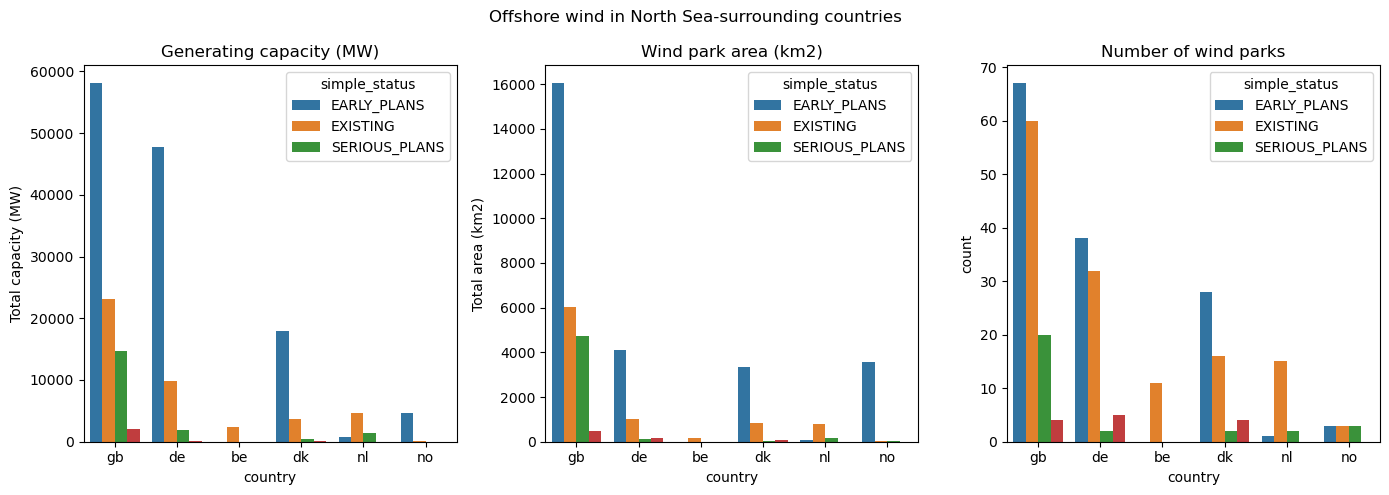

In [104]:
f, axs = plt.subplots(1,3,figsize=(14,5))
sns.barplot(merged_no, x="country", y="capacity", hue="simple_status", estimator="sum", errorbar=None, ax=axs[0])
axs[0].set_title("Generating capacity (MW)")
axs[0].set_ylabel("Total capacity (MW)")
sns.barplot(merged_no, x="country", y="mps_est_area_sqkm", hue="simple_status", estimator="sum", errorbar=None, ax=axs[1])
axs[1].set_title("Wind park area (km2)")
axs[1].set_ylabel("Total area (km2)")
sns.countplot(merged_no, x="country", hue="simple_status", ax=axs[2])
axs[2].set_title("Number of wind parks")
f.suptitle("Offshore wind in North Sea-surrounding countries")
f.tight_layout()

In [103]:
merged_no[merged_no.country=="no"]

,schema,aleph_id,name,status,country,value_eur,mps_id,source,properties.alephUrl,installed_capacity_mw,...,mps_uuid,capacity_mw,geometry,installation_year,mps_est_elevation_min_m,mps_est_shore_status,windfarm_type,mps_est_area_sqkm,capacity,simple_status
56,Asset,80a723b0-3d59-4983-9b20-d3ad5fd325d6.a2d2be5d4...,DEMONSTRASJONSANLEGG FOR OFFSHORE VINDKRAFT UT...,EXTENSION_REQUESTED,no,NaN,8d3e8677-6445-464d-ac0f-adf8ed6dc009,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/80a723b0-3...,NaN,...,8d3e8677-6445-464d-ac0f-adf8ed6dc009,10.0,"MULTIPOLYGON (((5.61638 59.07174, 5.62521 59.0...",NaN,-44.0,OFFSHORE,OFFSHORE_FIXED,1.203572,10.0,SERIOUS_PLANS
96,Asset,cc316355-43de-437f-aa31-3b4bee74d3c9.ac0d37837...,FLAGSHIP,CONSENT_AUTHORISED,no,NaN,b283b168-00a0-4d6e-90ca-c70ef87bdcaf,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/cc316355-4...,NaN,...,b283b168-00a0-4d6e-90ca-c70ef87bdcaf,11.0,"MULTIPOLYGON (((5.00092 59.12325, 5.00059 59.1...",2022.0,-232.0,OFFSHORE,OFFSHORE_FLOATING,0.986892,11.0,SERIOUS_PLANS
98,Asset,14cf4451-e5a2-4ff2-98e0-4393ac7adc17.e43bff8b3...,GOLIATVIND,PROJECT_ANNOUNCED,no,NaN,2b7ad6a0-05a4-4a38-94ed-ee38644d9c8b,"https://www.mapstand.com/, https://goliatvind.no/",[https://data.ftm.nl/api/2/entities/14cf4451-e...,NaN,...,2b7ad6a0-05a4-4a38-94ed-ee38644d9c8b,75.0,"MULTIPOLYGON (((22.23555 71.31745, 22.28047 71...",2030.0,-395.0,OFFSHORE,OFFSHORE_FLOATING,2.583894,75.0,EARLY_PLANS
133,Asset,d49cb4da-1729-4ae1-8f25-469d6ba890f5.0046e06b1...,HYWIND TAMPEN,OPERATIONAL,no,436000000,19af01af-e869-422b-8ce4-896d902b80cd,"https://www.mapstand.com/, https://www.thecrow...",[https://data.ftm.nl/api/2/entities/d49cb4da-1...,NaN,...,19af01af-e869-422b-8ce4-896d902b80cd,95.0,"MULTIPOLYGON (((2.25172 61.29382, 2.24000 61.3...",2022.0,-300.0,OFFSHORE,OFFSHORE_FLOATING,28.191499,95.0,EXISTING
179,Asset,a1fa2592-222b-474a-bc00-37558473b0c7.497fdf23b...,TETRASPAR DEMONSTRATOR (MARINE ENERGY TEST CEN...,OPERATIONAL,no,NaN,7c721516-034a-4b18-8292-7d1bdc276e5b,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/a1fa2592-2...,NaN,...,7c721516-034a-4b18-8292-7d1bdc276e5b,3.6,"MULTIPOLYGON (((5.01326 59.14754, 5.01293 59.1...",2021.0,-206.0,OFFSHORE,OFFSHORE_FLOATING,0.986197,3.6,EXISTING
193,Asset,e99074c6-d13f-4d78-aede-f60a131e60fb.cb7a9251a...,TEST AREA STADT,EXTENSION_REQUESTED,no,NaN,e22d69b8-4b1f-4c2e-a9de-cf2953407481,"https://www.mapstand.com/, https://www.nve.no/...",[https://data.ftm.nl/api/2/entities/e99074c6-d...,NaN,...,e22d69b8-4b1f-4c2e-a9de-cf2953407481,10.0,"MULTIPOLYGON (((4.85197 62.16757, 4.85197 62.2...",NaN,-220.0,OFFSHORE,OFFSHORE_FLOATING,40.119823,10.0,SERIOUS_PLANS
276,Asset,cd92662b-3ea8-46dd-a8cf-3aee390c3348.635996234...,UNITECH ZEFYROS (HYWIND DEMO/KARMOY) - METCENTRE,OPERATIONAL,no,NaN,7035febe-d427-4d11-8e4d-93ab47d4a969,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/cd92662b-3...,NaN,...,7035febe-d427-4d11-8e4d-93ab47d4a969,2.3,"MULTIPOLYGON (((5.02280 59.14330, 5.03329 59.1...",2009.0,-209.0,OFFSHORE,OFFSHORE_FIXED,0.437315,2.3,EXISTING
321,Asset,7ae638b7-afed-464c-9a9f-990754f121c5.4328767c9...,STRAUMOYA VINDKRAFTVERK,NaN,no,NaN,647feb6e-c92e-46a5-9590-8bebbcd020c5,NaN,[https://data.ftm.nl/api/2/entities/7ae638b7-a...,NaN,...,647feb6e-c92e-46a5-9590-8bebbcd020c5,25.0,"MULTIPOLYGON (((14.47364 67.23301, 14.47911 67...",NaN,-21.0,OFFSHORE,ONSHORE,2.851860,25.0,NaN
324,Asset,018b2ee6-dd02-46d4-839b-bfa8621d0dcd.93e6166c3...,UTSIRA NORD,AREA_PROPOSED,no,NaN,cf34dea4-5b4a-462c-b8b5-56c1ebcebcc7,NaN,[https://data.ftm.nl/api/2/entities/018b2ee6-d...,1500 MW,...,cf34dea4-5b4a-462c-b8b5-56c1ebcebcc7,NaN,"MULTIPOLYGON (((4.67687 59.47345, 4.68013 59.4...",NaN,-283.0,OFFSHORE,NaN,1001.770861,1500.0,EARLY_PLANS
325,Asset,0b3892f3-379c-4e97-9a6c-658f8c630812.0a870c00a...,SORLIGE NORDSJO II,AREA_PROPOSED,no,NaN,116dd036-d8f3-49b7-b63e-625b0020993e,NaN,[https://data.ftm.nl/api/2/entities/0b3892f3-3...,3000 MW,...,116dd036-d8f3-49b7-b63e-625b0020993e,NaN,"MULTI